# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

DATA_DIR = './data' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**

*Predict users performance based on their activity behaviour*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
# Your code for data processing goes here

### Here call your scripts for preprocessing, also explain the preprocessing steps that you did in general + data loss + graphs 

activity = pd.read_csv('{}/features/activity.csv'.format(DATA_DIR))
performances = pd.read_csv('{}/features/performances.csv'.format(DATA_DIR))

Unfortunately, many of the data points are not useable as our method relies on looking at the behaviour of the students and therefore the time spent on activities is important to us. In the following graph we can see the ammount of activity data that is of length 0 :

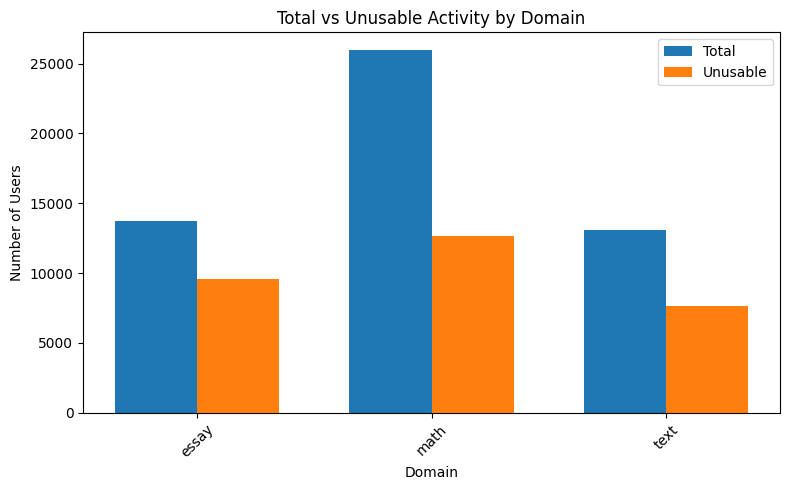

In [3]:
total = activity.groupby('domain')['user_id'].count()
unuseable = activity[activity['activity_completed'].isna()]
unuseable_count = unuseable.groupby('domain')['user_id'].count()

domains = sorted(set(total.index).union(set(unuseable_count.index)))
total = total.reindex(domains, fill_value=0)
unuseable_count = unuseable_count.reindex(domains, fill_value=0)

x = np.arange(len(domains))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, total, width, label='Total')
plt.bar(x + width/2, unuseable_count, width, label='Unusable')

plt.ylabel('Number of Users')
plt.xlabel('Domain')
plt.title('Total vs Unusable Activity by Domain')
plt.xticks(x, domains, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
print(f'By deleting these colums, we lose {(unuseable_count.sum()/total.sum() * 100).round(2)} % of the initial data ...')

By deleting these colums, we lose 56.67 % of the initial data ...


### Feature engineering 

**Our aim is to predict a user's score on their first attempt at a specific exam, based on their behavior leading up to it. To train our model, we engineered the following features to capture and characterize user behavior:**

- recent_avg_time_per_activity

*The average time (in minutes) spent per activity during the last 10 days before the exam, including the exam day. This reflects how intensely the user has been engaging recently.*

- days_since_last_activity

*The number of days between the user's most recent activity and the exam. A higher value may indicate a longer gap in studying before the exam.*

- total_time_spent_on_activity_before_exam

*The total amount of time (in minutes) the user spent on activities prior to the exam. This gives a sense of overall study investment leading up to the test.*

- average_percentage_past_exams

*The mean score percentage from the user's previous exams (before this one). This can provide a rough estimate of the user's historical performance.*

- avg_activities_per_day_recent

*The average number of activities completed per day in the 10-day rolling window. A higher number may suggest more consistent or intense preparation.*

- active_days_ratio_recent

*The proportion of days (out of 10) on which the user was active. This indicates how regularly they studied leading up to the exam.*

- diversity_recent

*The number of unique activity types completed in the rolling window. Higher diversity could reflect more varied engagement with different learning methods or content types.*


In [5]:
# Rolling window for recent activity
rolling_window_days = 10


def compute_all_features_for_exam(exam_row, user_activities, user_exams, window_days=rolling_window_days):

    exam_dt = exam_row['time']


    # Include activities up to and including exam_date
    previous_activities = user_activities[user_activities['activity_updated'] < exam_dt].copy()



    # Rolling window (activities in the last N days, including exam day)
    window_start = exam_dt - pd.Timedelta(days=window_days)
    rolling_activities = previous_activities[previous_activities['activity_updated'] >= window_start].copy()

    features = {}


    # Recent average time per activity (rolling window)
    total_time_rolling = rolling_activities['time_in_minutes'].sum()
    count_rolling = len(rolling_activities)
    features['recent_avg_time_per_activity'] = total_time_rolling / count_rolling if count_rolling > 0 else 0


    # Number of days since last activity
    if not previous_activities.empty:
        last_activity_date = previous_activities['activity_updated'].max()
        features['days_since_last_activity'] = (exam_dt - last_activity_date).days
    else:
        features['days_since_last_activity'] = np.nan


    # Total time spent on activities before the exam
    features['total_time_spent_on_activity_before_exam'] = previous_activities['time_in_minutes'].sum() if not previous_activities.empty else 0


    # Average percentage on past exams
    previous_exams = user_exams[user_exams['time'] < exam_dt]
    features['average_percentage_past_exams'] = previous_exams['percentage'].mean() if not previous_exams.empty else np.nan ###### HERE WE NEED TO FIX


    # Usage Frequency: Average activities per day in rolling window & Active days ratio
    features['avg_activities_per_day_recent'] = count_rolling / window_days if window_days > 0 else np.nan
    if not rolling_activities.empty:
        distinct_days = rolling_activities['activity_updated'].dt.normalize().nunique()
    else:
        distinct_days = 0
    features['active_days_ratio_recent'] = distinct_days / window_days if window_days > 0 else np.nan


    # Activity diversity (rolling window)
    features['diversity_recent'] = rolling_activities['activity_type'].nunique() if not rolling_activities.empty else 0


    return pd.Series(features)


**All features are calculated separately within each domain — Math, Text, and Essay — to capture domain-specific learning patterns and engagement.**

We have also scaled the features using a standard because we assume a normal distribution

In [6]:
scaler = StandardScaler()
columns_to_scale = ['recent_avg_time_per_activity', 'days_since_last_activity', 'total_time_spent_on_activity_before_exam','average_percentage_past_exams','avg_activities_per_day_recent','diversity_recent']

#### Math data 

In [7]:
performances_math = performances[performances['domain']== 'math'].copy()
activity_math = activity[activity['domain']== 'math'].copy()

# Convert the 'date' columns to datetime
activity_math['activity_updated'] = pd.to_datetime(activity_math['activity_updated'])
performances_math['time'] = pd.to_datetime(performances_math['time'])

# Loop over each exam (grouped by user) in performances_math and compute all features.
features_list = []

for user_id, user_exams in performances_math.groupby('user_id'):
    # Get corresponding activities for the user from activity_math and sort by date
    user_activities = activity_math[activity_math['user_id'] == user_id].sort_values('activity_updated')
    user_exams_sorted = user_exams.sort_values('time')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_math_features = performances_math.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_math_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_math_features.index)
remaining_df = performances_math_features.drop(columns=columns_to_scale)
final_df_math = pd.concat([scaled_df, remaining_df], axis=1)

In [8]:
final_df_math.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                      5
total_time_spent_on_activity_before_exam      0
average_percentage_past_exams               469
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [9]:
print('Total Nb of rows :', final_df_math.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_math.isna().any(axis=1).sum())
final_df_math.dropna(inplace=True)

Total Nb of rows : 3810
Nb of rows where we are missing feature values : 469


#### Essay data

In [10]:
performances_essay = performances[performances['domain']== 'essay'].copy()
activity_essay= activity[activity['domain']== 'essay'].copy()

# Convert the date columns  to datetime
activity_essay['activity_updated'] = pd.to_datetime(activity_essay['activity_updated'])
performances_essay['time'] = pd.to_datetime(performances_essay['time'])

# Loop over each exam (grouped by user) in performances_essay and compute all features.
features_list = []

for user_id, user_exams in performances_essay.groupby('user_id'):
    # Get corresponding activities for the user from activity_essay and sort by date
    user_activities = activity_essay[activity_essay['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_essay_features = performances_essay.join(features_df, how='left')


# scaling the columns
scaled_values = scaler.fit_transform(performances_essay_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_essay_features.index)
remaining_df = performances_essay_features.drop(columns=columns_to_scale)
final_df_essay = pd.concat([scaled_df, remaining_df], axis=1)

In [11]:
final_df_essay.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                     47
total_time_spent_on_activity_before_exam      0
average_percentage_past_exams               308
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [12]:
print('Total Nb of rows :', final_df_essay.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_essay.isna().any(axis=1).sum())
final_df_essay.dropna(inplace=True)

Total Nb of rows : 581
Nb of rows where we are missing feature values : 331


#### Text data 

In [13]:
performances_text = performances[performances['domain']== 'text'].copy()
activity_text= activity[activity['domain']== 'text'].copy()

# Convert the date columns to datetime
activity_text['activity_updated'] = pd.to_datetime(activity_text['activity_updated'])
performances_text['time'] = pd.to_datetime(performances_text['time'])

# Loop over each exam (grouped by user) in performances_text and compute all features.
features_list = []

for user_id, user_exams in performances_text.groupby('user_id'):
    # Get corresponding activities for the user from activity_text and sort by date
    user_activities = activity_text[activity_text['user_id'] == user_id].sort_values('date')
    user_exams_sorted = user_exams.sort_values('date')

    for exam_index, exam_row in user_exams_sorted.iterrows():
        feats = compute_all_features_for_exam(exam_row, user_activities, user_exams_sorted, rolling_window_days)
        feats['exam_index'] = exam_index
        features_list.append(feats)

# Output df
features_df = pd.DataFrame(features_list).set_index('exam_index')
performances_text_features = performances_text.join(features_df, how='left')


# Scale the columns
scaled_values = scaler.fit_transform(performances_text_features[columns_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale, index=performances_text_features.index)
remaining_df = performances_text_features.drop(columns=columns_to_scale)
final_df_text = pd.concat([scaled_df, remaining_df], axis=1)

In [14]:
final_df_text.isnull().sum()

recent_avg_time_per_activity                  0
days_since_last_activity                     32
total_time_spent_on_activity_before_exam      0
average_percentage_past_exams               122
avg_activities_per_day_recent                 0
diversity_recent                              0
user_id                                       0
domain                                        0
test_id                                       0
course                                        0
date                                          0
time                                          0
percentage                                    0
performance                                   0
active_days_ratio_recent                      0
dtype: int64

In [15]:
print('Total Nb of rows :', final_df_text.user_id.count())
print('Nb of rows where we are missing feature values :', final_df_text.isna().any(axis=1).sum())

final_df_text.dropna(inplace=True)

Total Nb of rows : 445
Nb of rows where we are missing feature values : 141


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

In [16]:
# Your code for training a model goes here

# Linear Regression Model
mod_math = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_percentage_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_math)
# Fit the model
res_math = mod_math.fit()
# Print regression results summary
print(res_math.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     167.5
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          1.21e-186
Time:                        16:34:52   Log-Likelihood:                -15505.
No. Observations:                3341   AIC:                         3.102e+04
Df Residuals:                    3334   BIC:                         3.107e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [17]:
# Linear Regression Model
mod_essay = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_percentage_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_essay)
# Fit the model
res_essay = mod_essay.fit()
# Print regression results summary
print(res_essay.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6.364
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           3.08e-06
Time:                        16:34:52   Log-Likelihood:                -996.09
No. Observations:                 250   AIC:                             2006.
Df Residuals:                     243   BIC:                             2031.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [18]:
# Linear Regression Model
mod_text = smf.ols(formula='performance ~  recent_avg_time_per_activity + days_since_last_activity + total_time_spent_on_activity_before_exam + average_percentage_past_exams + avg_activities_per_day_recent + diversity_recent', data=final_df_text)
# Fit the model
res_text = mod_text.fit()
# Print regression results summary
print(res_text.summary())

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.997
Date:                Thu, 17 Apr 2025   Prob (F-statistic):            0.00739
Time:                        16:34:52   Log-Likelihood:                -1209.3
No. Observations:                 304   AIC:                             2433.
Df Residuals:                     297   BIC:                             2459.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [19]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*